In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.impute import SimpleImputer, KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from scipy.stats import ks_2samp
import pickle
import torch
import sklearn
from sklearn.datasets import  make_classification, make_regression
from imblearn.under_sampling import RandomUnderSampler 

In [2]:
os.chdir('..')

In [3]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [4]:
prediction_window = ""

In [5]:
data_directory = 'Sepsis Data/'
prediction_directory = 'sepsis/'

data_files = find_csv_filenames(data_directory+prediction_directory)

hosps = [x.replace('.csv', '') for x in data_files]

In [6]:
data_dictionary = dict.fromkeys(hosps)

In [7]:
for file in data_files:
    data = pd.read_csv(data_directory + prediction_directory + file)
    
    demographic_index = list(data).index('is_female')
    medical_signs = list(data)[:demographic_index]
    demographic_data = ['is_female', 'age', 'race_black', 'race_hispanic', 'race_asian', 
                        'race_other', 'electivesurgery', 'BMI']
    medication_index = list(data).index('ACETAMIN')
    medications = list(data)[medication_index:len(list(data))-1]
    AKI_diag = list(data)[-1]
    numerical_col = medical_signs + ['age', 'BMI']
    categorical_col = medications + ['is_female', 'race_black', 'race_hispanic', 'race_asian', 'race_other', 'electivesurgery']
    
    hosp = file.replace('.csv', '')
    
    data_dictionary[hosp] = data[demographic_data + [AKI_diag]]
    
print("Done Creating all Cleaned Data")

Done Creating all Cleaned Data


#### Creating Demographic Distribution Chart

In [8]:
data_dictionary["73"].head()

,is_female,age,race_black,race_hispanic,race_asian,race_other,electivesurgery,BMI,sepsis_label
0,0.0,68.0,0.0,0.0,0.0,1.0,0.0,22.732803,0.0
1,1.0,81.0,0.0,0.0,0.0,1.0,1.0,22.635548,0.0
2,0.0,63.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0
3,0.0,63.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0
4,0.0,63.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0


In [9]:
hosp_titles = ["ID " + x for x in hosps]

age_dictionary = dict.fromkeys(hosp_titles) 
gend_dictionary = dict.fromkeys(hosp_titles) 
race_dictionary = dict.fromkeys(hosp_titles) 
surg_dictionary = dict.fromkeys(hosp_titles)
bmi_dictionary = dict.fromkeys(hosp_titles)
aki_dictionary = dict.fromkeys(hosp_titles)
total_dictionary = dict.fromkeys(hosp_titles)

In [10]:
for hosp in data_dictionary:
    
    df = data_dictionary[hosp]
    hosp = "ID " + hosp
    
    # Gender
    num_female = (df['is_female'] == 1.0).sum()
    num_male = (df['is_female'] == 0.0).sum()
    gend_dictionary[hosp] = [num_female, num_male]
    
    # Race
    num_black = (df['race_black'] == 1.0).sum()
    num_hispanic = (df['race_hispanic'] == 1.0).sum()
    num_asian = (df['race_asian'] == 1.0).sum()
    num_other = (df['race_other'] == 1.0).sum()
    race_dictionary[hosp] = [num_black, num_hispanic, num_asian, num_other]
    
    # Age
    num1 = (df['age'] <= 25).sum()
    num2 = len(df[(df['age'] > 25) & (df['age'] <= 50)])
    num3 = len(df[(df['age'] > 50) & (df['age'] <= 75)])
    num4 = (df['age'] > 75).sum()
    age_dictionary[hosp] = [num1, num2, num3, num4]
    
    # Surgery
    num_yes = (df['electivesurgery'] == 1.0).sum()
    num_no = (df['electivesurgery'] == 0.0).sum()
    surg_dictionary[hosp] = [num_yes, num_no]
    
    # BMI
    num1 = (df['BMI'] <= 23).sum()
    num2 = len(df[(df['BMI'] > 23) & (df['BMI'] <= 28)])
    num3 = len(df[(df['BMI'] > 28) & (df['BMI'] <= 34)])
    num4 = (df['BMI'] > 34).sum()
    bmi_dictionary[hosp] = [num1, num2, num3, num4]
    
    # Sepsis
    num1 = (df['sepsis_label'] == 1.0).sum()
    num2 = (df['sepsis_label'] == 0.0).sum()
    aki_dictionary[hosp] = [num1, num2]
    
    # Total
    total_dictionary[hosp] = [df.shape[0]]

In [11]:
gender_df = pd.DataFrame(data = gend_dictionary, index=['Female', 'Male'])
race_df = pd.DataFrame(data = race_dictionary, index=['Black', 'Hispanic', 'Asian', 'Other'])
surg_df = pd.DataFrame(data = surg_dictionary, index=['Elective Surgery: Yes', 'Elective Surgery: No'])
bmi_df = pd.DataFrame(data = bmi_dictionary, index=['BMI < 23', '23 < BMI < 28', '28 < BMI < 34', 
                                                    'BMI > 34'])
age_df = pd.DataFrame(data = age_dictionary, index=["Age < 25", "25 < Age < 50", "50 < Age < 75", 
                                                    "Age > 75"])
aki_df = pd.DataFrame(data = aki_dictionary, index=["Positive", "Negative"])
total_df = pd.DataFrame(data = total_dictionary, index=["Total"])

In [12]:
gender_df_freq = gender_df.div(gender_df.sum(axis=0), axis=1).round(2)
race_df_freq = race_df.div(race_df.sum(axis=0), axis=1).round(2)
surg_df_freq = surg_df.div(surg_df.sum(axis=0), axis=1).round(2)
bmi_df_freq = bmi_df.div(bmi_df.sum(axis=0), axis=1).round(2)
age_df_freq = age_df.div(age_df.sum(axis=0), axis=1).round(2)
aki_df_freq = aki_df.div(aki_df.sum(axis=0), axis=1).round(2)

In [13]:
final_gender_df = gender_df.astype(str) + " (" + gender_df_freq.astype(str) + ")" 
final_race_df = race_df.astype(str) + " (" + race_df_freq.astype(str) + ")" 
final_surg_df = surg_df.astype(str) + " (" + surg_df_freq.astype(str) + ")" 
final_bmi_df = bmi_df.astype(str) + " (" + bmi_df_freq.astype(str) + ")" 
final_age_df = age_df.astype(str) + " (" + age_df_freq.astype(str) + ")"
final_aki_df = aki_df.astype(str) + " (" + aki_df_freq.astype(str) + ")"

In [14]:
separator = pd.DataFrame(columns=hosp_titles)
separator.loc[""] = [""]*7

In [15]:
dem_df = pd.concat([total_df, separator, final_gender_df, separator, final_race_df, separator,
          final_surg_df, separator, final_bmi_df, separator, final_age_df, separator, final_aki_df])
dem_df

,ID 420,ID 122,ID 243,ID 252,ID 458,ID 199,ID 73
Total,2276,2365,3212,2586,2748,2996,5919
,,,,,,,
Female,936 (0.41),1085 (0.46),1404 (0.44),1097 (0.42),1234 (0.45),1293 (0.43),2629 (0.44)
Male,1340 (0.59),1280 (0.54),1808 (0.56),1489 (0.58),1514 (0.55),1703 (0.57),3290 (0.56)
,,,,,,,
Black,100 (0.04),553 (0.23),1019 (0.32),175 (0.07),805 (0.29),44 (0.01),899 (0.15)
Hispanic,2 (0.0),0 (0.0),0 (0.0),0 (0.0),0 (0.0),36 (0.01),428 (0.07)
Asian,43 (0.02),12 (0.01),31 (0.01),10 (0.0),38 (0.01),3 (0.0),82 (0.01)
Other,2131 (0.94),1800 (0.76),2162 (0.67),2401 (0.93),1905 (0.69),2913 (0.97),4510 (0.76)
,,,,,,,


#### Medication Investigation

In [16]:
data_dictionary = dict.fromkeys(hosps)

In [17]:
for file in data_files:
    data = pd.read_csv(data_directory + prediction_directory + file)
    
    demographic_index = list(data).index('is_female')
    medical_signs = list(data)[:demographic_index]
    demographic_data = ['is_female', 'age', 'race_black', 'race_hispanic', 'race_asian', 
                        'race_other', 'electivesurgery', 'BMI']
    medication_index = list(data).index('ACETAMIN')
    medications = list(data)[medication_index:len(list(data))-1]
    AKI_diag = list(data)[-1]
    numerical_col = medical_signs + ['age', 'BMI']
    categorical_col = medications + ['is_female', 'race_black', 'race_hispanic', 'race_asian', 'race_other', 'electivesurgery']
    
    hosp = file.replace('.csv', '')
    
    data_dictionary[hosp] = data
    
print("Done Creating all Cleaned Data")

Done Creating all Cleaned Data


In [18]:
medication_count_dfs = []
for hosp in hosps:
    data = data_dictionary[hosp][medications]
    hosp_medication_counts = data.sum(axis = 0, skipna = True)
    hosp_medication_counts = hosp_medication_counts.to_frame().rename(columns={0:hosp})
    medication_count_dfs.append(hosp_medication_counts)

medication_counts = pd.concat(medication_count_dfs, axis=1)
medication_props = medication_counts.div(medication_counts.sum(axis=0), axis=1)

##### A Frequency Plot Depicting Commonality of Medications Across Hospitals
Counts of how often each medication appears across hospitals were aggregated  
X-Axis indicates how many hospitals have at least one patient on the medication (commonality)  
Y-Axis indicates the amount of medications that are used at the corresponding X-value # hospitals  
e.g. 80+ medications are not present/in use at any hospital

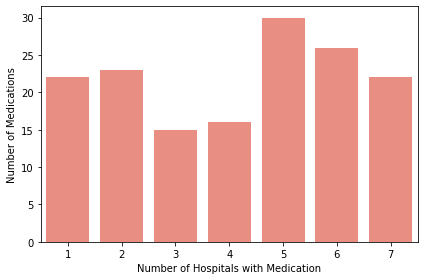

In [19]:
num_hosps_with_med = np.count_nonzero(medication_props, axis=1)
med_count, freqs = np.unique(num_hosps_with_med, return_counts=True)
df_data = pd.DataFrame(data={'MED_COUNT':med_count, 'FREQS':freqs})
df_data = df_data[df_data['MED_COUNT'] > 0]

sns.barplot(x = "MED_COUNT", y = "FREQS",
            data = df_data, color="salmon")
plt.xlabel("Number of Hospitals with Medication", size=10)
plt.ylabel("Number of Medications", size=10)
# plt.title("Frequency Plot of Medications and their Commonality Across Hospitals", size=12)
plt.tight_layout()

##### Histogram - Disagreement (IQR) of Medication Usage Across Hospitals 
X-Axis indicates the IQRs of the proportions of patients that use a medication across hospitals  
Y-Axis indicates counts of different IQR bins  
** Note: Less than 237 medications because medications where all hospitals have no patients were removed

In [20]:
medication_props_dg = copy.deepcopy(medication_props)
medication_props_dg['IQR'] = None
for index in medication_props.index:
    medication_vals = medication_props.loc[index].values
    if np.count_nonzero(medication_vals) > 1:
        q75, q25 = np.percentile(medication_vals, [75 ,25])
        iqr = q75 - q25
        medication_props_dg.at[index, 'IQR'] = iqr
        stdev = np.std(medication_vals)
        medication_props_dg.at[index, 'StdDev'] = stdev
    
medication_props_dg_filtered = medication_props_dg.loc[~(medication_props_dg==0).all(axis=1)]
medication_props_iqr_filtered = medication_props_dg_filtered.sort_values(by=['IQR'], ascending=False)
medication_props_std_filtered = medication_props_dg_filtered.sort_values(by=['StdDev'], ascending=False)

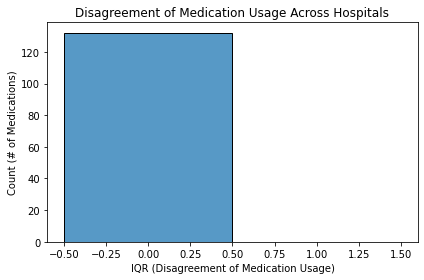

In [21]:
sns.histplot(data=medication_props_dg_filtered, x="IQR")
plt.xlabel("IQR (Disagreement of Medication Usage)", size=10)
plt.ylabel("Count (# of Medications)", size=10)
plt.title("Disagreement of Medication Usage Across Hospitals", size=12)
plt.tight_layout()

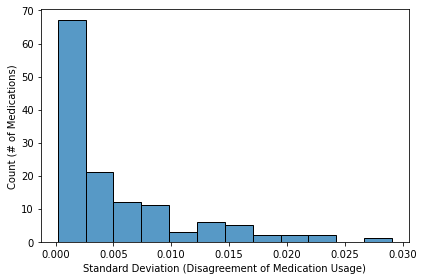

In [22]:
sns.histplot(data=medication_props_dg_filtered, x="StdDev")
plt.xlabel("Standard Deviation (Disagreement of Medication Usage)", size=10)
plt.ylabel("Count (# of Medications)", size=10)
# plt.title("Disagreement of Medication Usage Across Hospitals", size=12)
plt.tight_layout()

#### Dissimalrity of Features Between all Hospitals
Use Kolmogorov–Smirnov test for similarity  
Create n x n matrix (where n is the number of hospitals) for each feature and populate it with the similarity measure between each pair of hospitals. Take the mean of this matrix (or standard deviation?) --> dissimilarity of the feature across hospitals

In [23]:
data_dictionary = dict.fromkeys(hosps)
for file in data_files:
    data = pd.read_csv(data_directory + prediction_directory + file)
    
    demographic_index = list(data).index('is_female')
    medical_signs = list(data)[:demographic_index]
    demographic_data = ['is_female', 'age', 'race_black', 'race_hispanic', 'race_asian', 
                        'race_other', 'electivesurgery', 'BMI']
    medication_index = list(data).index('ACETAMIN')
    medications = list(data)[medication_index:len(list(data))-1]
    AKI_diag = list(data)[-1]
    numerical_col = medical_signs + ['age', 'BMI']
    categorical_col = medications + ['is_female', 'race_black', 'race_hispanic', 'race_asian', 'race_other', 'electivesurgery']
    
    hosp = file.replace('.csv', '')
    
    data_dictionary[hosp] = data
    
print("Done Creating all Cleaned Data")

Done Creating all Cleaned Data


In [24]:
def pairwiseDifference(arr): 
    diff_list = []
    increase_sum = 0
    current_diff = 1
    for i in range(len(arr) - 1) :
        diff = abs(arr[i] - arr[i + 1])
        if diff > current_diff:
            increase_sum += diff
        current_diff = diff
        diff_list.append(diff)
    return diff_list, increase_sum

# Dissimilarity Score Calculation
## Trying to detect sudden differences between feature similairties across hospitals
## Sort values by ascending in array and then scale up so that maximum value is 1
## Get pairwise differences between consecutive values in sorted feature similarities array
## Sum up increases in dissimilarities --> this is the dissimilarity score

def calculate_dissimalirity_score(arr):
    try:
        arr = np.sort(arr)
        arr = arr/np.max(arr)
        b, increase_sum = pairwiseDifference(arr)
    except:
        increase_sum = 0
    return increase_sum

In [25]:
# feats = list(data_dictionary['420'])
# feats.remove('sepsis_label')
# feat_matrices_dict = dict.fromkeys(feats)

# for i, feature in enumerate(feats):
#     df_feat = pd.DataFrame(index=hosps, columns=hosps, dtype="float")
#     for hosp_a in hosps:
#         for hosp_b in hosps:
#             hosp_a_feat = data_dictionary[hosp_a][feature].values
#             hosp_b_feat = data_dictionary[hosp_b][feature].values
#             dist_stat = MMD(torch.tensor(hosp_a_feat), torch.tensor(hosp_b_feat))
#             df_feat.at[hosp_a, hosp_b] = dist_stat
#     feat_matrices_dict[feature] = df_feat
#     print("Done with " + str(i+1) + " out of " + str(len(feats)) + " features", end="\r")
    
# feat_avgds_dict = dict.fromkeys(feats)
# feat_stds_dict = dict.fromkeys(feats)
# feat_ds_dict = dict.fromkeys(feats)
# for feat in feat_matrices_dict:
#     feat_arr = feat_matrices_dict[feat].values
#     feat_arr = feat_arr[np.triu_indices(feat_arr.shape[0], k = 1)]
#     feat_avgds_dict[feat] = np.mean(feat_arr)
#     feat_stds_dict[feat] = np.std(feat_arr)
#     feat_ds_dict[feat] = calculate_dissimalirity_score(feat_arr)

# feat_ds_df = pd.DataFrame(data = {"features":feat_avgds_dict.keys(), "avg_score":feat_avgds_dict.values(),
#                                   "std_score":feat_stds_dict.values(), "dissimalirity_score":feat_ds_dict.values()})
# num_features_df = feat_ds_df[feat_ds_df['features'].isin(numerical_col)]
# num_features_df['categorical'] = False
# cat_features_df = feat_ds_df[feat_ds_df['features'].isin(categorical_col)]
# cat_features_df['categorical'] = True
# feat_ds_df = pd.concat([num_features_df, cat_features_df])

# feat_ds_df.to_csv('Sepsis Data/Feature_Dissimilarities.csv', index=False)
# feat_ds_df.head()

In [26]:
# feature = list(feat_matrices_dict.keys())[-10]
# feature = 'NITROGLYCERIN'
# df_feat = feat_matrices_dict[feature].astype(float)
# ax = sns.heatmap(data=df_feat, annot=df_feat.values)

# plt.ylabel("Hospital ID", size=12)
# plt.xlabel("Hospital ID", size=12)
# plt.xticks(rotation = 90)
# plt.title(f"{feature} Matrix", size=16)
# print(f"Feature Dissimilarity Score: {feat_ds_dict[feature]}")

In [27]:
# hist_orig = data_dictionary['420'][feature].hist(bins=10)
# hist_similar = data_dictionary['122'][feature].hist(bins=10)
# hist_dissimilar = data_dictionary['73'][feature].hist(bins=10)

#### Mutual Information Investigation

In [28]:
data_cleaned_dictionary = dict.fromkeys(hosps)
for hosp in data_dictionary:
    file = str(hosp) + '.csv'
    data = pd.read_csv(data_directory + prediction_directory + "cleaned/" + file)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data_cleaned_dictionary[hosp] = data

In [29]:
# all_info = []

# for hosp in data_cleaned_dictionary:
#     feats = list(data_cleaned_dictionary[hosp])
#     feats.remove('sepsis_label')
#     X = data_cleaned_dictionary[hosp][feats]
#     y = data_cleaned_dictionary[hosp]['sepsis_label'].astype(int)
#     infos = sklearn.feature_selection.mutual_info_classif(X, y,
#                                                   discrete_features='auto',
#                                                   n_neighbors=3)
#     all_info.append(infos)

# all_info = np.array(all_info).T
# df_minfo = pd.DataFrame(data=all_info, index=feats, columns=data_cleaned_dictionary.keys())

In [30]:
# df_minfo_rankings = pd.DataFrame(index=feats, columns=data_cleaned_dictionary.keys())
# for col in list(df_minfo):
#     df_minfo_rankings[col] = df_minfo[col].rank(ascending=False).values

In [31]:
# df_minfo['mi_mean'] = np.mean(df_minfo[hosps].values, axis=1)
# df_minfo['mi_std'] = np.std(df_minfo[hosps].values, axis=1)

In [32]:
# df_minfo

#### General Statistics of Hospitals

In [33]:
data_patient = pd.read_csv('General Data/patient.csv')
data_patient['hospitalid'] = data_patient['hospitalid'].astype(str)
data_patient = data_patient[data_patient['hospitalid'].isin(hosps)]

data_hosp = pd.read_csv('General Data/hospital.csv')
data_hosp['hospitalid'] = data_hosp['hospitalid'].astype(str)
data_hosp = data_hosp[data_hosp['hospitalid'].isin(hosps)]

In [34]:
data_patient_dfs = dict.fromkeys(hosps)
unit_type_df = pd.DataFrame(index=pd.unique(data_patient['unittype'].values))
admit_source_df = pd.DataFrame(index=pd.unique(data_patient['unitadmitsource'].values))
region_df = pd.DataFrame(index=['Region'])
bed_df = pd.DataFrame(index=['Number of Beds'])

for hosp in data_patient_dfs:
    data_patient_hosp = data_patient[data_patient['hospitalid'] == hosp]
    t = data_patient_hosp['unittype'].value_counts().to_frame().rename(columns={'unittype':hosp})
    unit_type_df = unit_type_df.join(t)
    t = data_patient_hosp['unitadmitsource'].value_counts().to_frame().rename(columns={'unitadmitsource':hosp})
    admit_source_df = admit_source_df.join(t)
    region_df[hosp] = data_hosp[data_hosp['hospitalid'] == hosp]['region'].values[0]
    bed_df[hosp] = data_hosp[data_hosp['hospitalid'] == hosp]['numbedscategory'].values[0]
    data_patient_dfs[hosp] = data_patient_hosp
    
unit_type_df = unit_type_df.fillna(0).astype(int)
admit_source_df = admit_source_df.fillna(0).astype(int)
unit_type_df = unit_type_df.loc[~(unit_type_df==0).all(axis=1)]
admit_source_df = admit_source_df.loc[~(admit_source_df==0).all(axis=1)]
unit_type_df.columns = ["ID " + x for x in hosps]
admit_source_df.columns = ["ID " + x for x in hosps]
region_df.columns = ["ID " + x for x in hosps]
bed_df.columns = ["ID " + x for x in hosps]

unit_type_df_freq = unit_type_df.div(unit_type_df.sum(axis=0), axis=1).round(2)
admit_source_df_freq = admit_source_df.div(admit_source_df.sum(axis=0), axis=1).round(2)

final_unit_type_df = unit_type_df.astype(str) + " (" + unit_type_df_freq.astype(str) + ")"
final_admit_source_df = admit_source_df.astype(str) + " (" + admit_source_df_freq.astype(str) + ")"

In [35]:
unittype_section_title = pd.DataFrame(columns=hosp_titles, index=['Unit Type'])
unittype_section_title.loc['Unit Type'] = [""]*7
unitsource_section_title = pd.DataFrame(columns=hosp_titles, index=['Patient Admit Source'])
unitsource_section_title.loc['Patient Admit Source'] = [""]*7

In [36]:
extended_dem_df = pd.concat([region_df, separator, bed_df, separator, unittype_section_title,
                             final_unit_type_df, separator, unitsource_section_title,
                             final_admit_source_df])
pd.set_option('display.max_rows', extended_dem_df.shape[0])
extended_dem_df.head(100)

,ID 420,ID 122,ID 243,ID 252,ID 458,ID 199,ID 73
Region,Northeast,South,South,Midwest,South,Northeast,Midwest
,,,,,,,
Number of Beds,>= 500,>= 500,>= 500,>= 500,>= 500,>= 500,>= 500
,,,,,,,
Unit Type,,,,,,,
CTICU,0 (0.0),562 (0.19),0 (0.0),0 (0.0),635 (0.17),0 (0.0),1364 (0.19)
Med-Surg ICU,1343 (0.29),1495 (0.51),11 (0.0),0 (0.0),0 (0.0),3712 (0.88),1159 (0.16)
SICU,1932 (0.41),0 (0.0),710 (0.17),588 (0.17),372 (0.1),0 (0.0),408 (0.06)
CCU-CTICU,706 (0.15),0 (0.0),0 (0.0),1031 (0.31),0 (0.0),0 (0.0),1510 (0.21)
MICU,0 (0.0),0 (0.0),778 (0.18),914 (0.27),446 (0.12),528 (0.12),1124 (0.16)
